# PDEfind Usage Examples

We discuss how to use the PDEfind library on specific examples. 

## Diffusion equation (1D)

Consider the equation 
$$\partial_t u(t,x) = \partial_x^2 u(t,x)$$
on $(t, x) \in [0,1] \times [0,1]$ with Dirichlet boundary conditions.

First, prepare the mock data.

In [1]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dxx = Differential(x)^2

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ Dxx(u(t, x))
bcs = [u(0, x) ~ 2.5*sin(pi*x),
        u(t, 0) ~ 0.0,
        u(t, 1) ~ 0.0]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.01
order = 2
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.01)

PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (101, 101) sized solution
  Domain:
    t ∈ (0.0, 1.0) with 101 points, step size 0.01


L"\begin{align}
 - \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) =& 0
\end{align}
"

    x ∈ (0.0, 1.0) with 101 points, step size 0.01
  From system:
    Equations:


L"\begin{align}
u\left( 0, x \right) =& 2.5 \sin\left( \pi x \right) \\
u\left( t, 0 \right) =& 0 \\
u\left( t, 1 \right) =& 0
\end{align}
"

    Boundary/Initial Conditions:


Import the package

In [2]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [3]:
# start with given data
data_array = sol(0.0:0.01:1.0,0.0:0.02:1.0)[1]
time_array = collect(0.0:0.01:1.0)
space_array= collect(0.0:0.02:1.0)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18  …  0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0], 0.01, 0.02, 101, 51, 5151, [0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0; … ; 0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0], [0.0 0.0 … 0.0 0.0; 0.02 0.02 … 0.02 0.02; … ; 0.98 0.98 … 0.98 0.98; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u_(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

Note: `normalization_factors` are an irrelevant trick used for stability of the algorithm.

In [4]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4) # takes BC and order as arguments
max_derivative = 2
variables_matrix = GetVariablesMatrix(max_derivative, data_array, g, ∂x)

# construct basis functions, eg: polynomial basis
max_degree = 2
n_variables = max_derivative + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_degree, n_variables, skip_constant = true)

# theta matrix
Θ, normalization_factors = evaluate(MyBasis, variables_matrix, normalize_columns = false)

([0.0 7.853957301761645 … -0.014866380323646919 3.582889434801662e-6; 0.0 7.115553672051445 … -0.012069447824787752 2.877116221346731e-6; … ; 0.0 -0.0004484369137866854 … 4.8465296417449014e-11 1.168043552445289e-14; 0.0 -0.0004070845533276938 … 3.993902117576064e-11 9.625550722152652e-15], nothing)

Perform sequential thresholded ridge regression. 

In [5]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis, λ = 1e-2, tol = 2e-3, iters = 4, verbose = true)

Iterations to go: 4, Tolerance: 0.002, λ = 0.01


Current fit: 
 $ \\ \partial_t u = p_{100}u + \textcolor{grey}{p_{010}\partial_{x} u} + p_{001}\partial_{xx} u + \textcolor{grey}{p_{200}(u)^2} + \textcolor{grey}{p_{110}u\partial_{x} u} + \textcolor{grey}{p_{101}u\partial_{xx} u} + \textcolor{grey}{p_{020}(\partial_{x} u)^2} + \textcolor{grey}{p_{011}\partial_{x} u\partial_{xx} u} + \textcolor{grey}{p_{002}(\partial_{xx} u)^2} \\ $ with: $ \\p_{100} = -0.002 \\ \textcolor{grey}{p_{010} = 0.0 \\ }p_{001} = 0.0201 \\ \textcolor{grey}{p_{200} = -0.0 \\ }\textcolor{grey}{p_{110} = -0.0 \\ }\textcolor{grey}{p_{101} = 0.0 \\ }\textcolor{grey}{p_{020} = 0.0001 \\ }\textcolor{grey}{p_{011} = 0.0 \\ }\textcolor{grey}{p_{002} = 0.0 \\ }$ 
 - - -

Iterations to go: 3, Tolerance: 0.002, λ = 0.01


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{p_{100}u} + p_{001}\partial_{xx} u \\ $ with: $ \\\textcolor{grey}{p_{100} = -0.002 \\ }p_{001} = 0.0196 \\ $ 
 - - -

Iterations to go: 2, Tolerance: 0.002, λ = 0.01


Current fit: 
 $ \\ \partial_t u = p_{001}\partial_{xx} u \\ $ with: $ \\p_{001} = 0.0198 \\ $ 
 - - -

Iterations to go: 1, Tolerance: 0.002, λ = 0.01


Current fit: 
 $ \\ \partial_t u = p_{001}\partial_{xx} u \\ $ with: $ \\p_{001} = 0.0198 \\ $ 
 - - -

1-element Vector{Float64}:
 0.01983986738495586

In [8]:
println(normalization_factors)

nothing


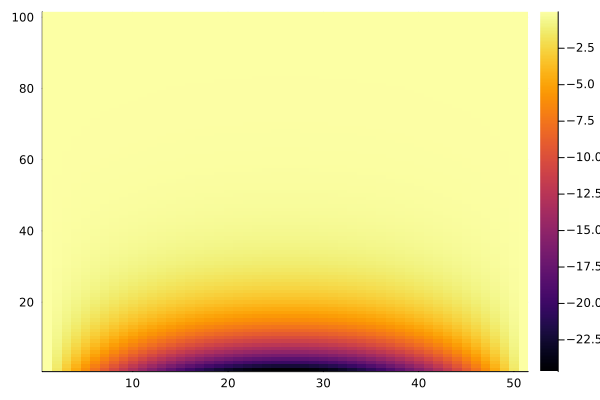

In [10]:
# check stabilities of derivatives
using Plots
display(heatmap(reshape(variables_matrix[3],(g.nt,g.nx))))